Processing...
System-wide aggregated %Diff per period:
Period
Evening Shed   -71.735965
Full Day        -1.501876
Morning Shed   -77.743069
Name: %Diff, dtype: float64

Per-home stats:
Evening Shed: median ~ -89.07%, mean ~ -51.82%
Full Day: median ~ -0.73%, mean ~ -0.66%
Morning Shed: median ~ -97.30%, mean ~ -51.59%


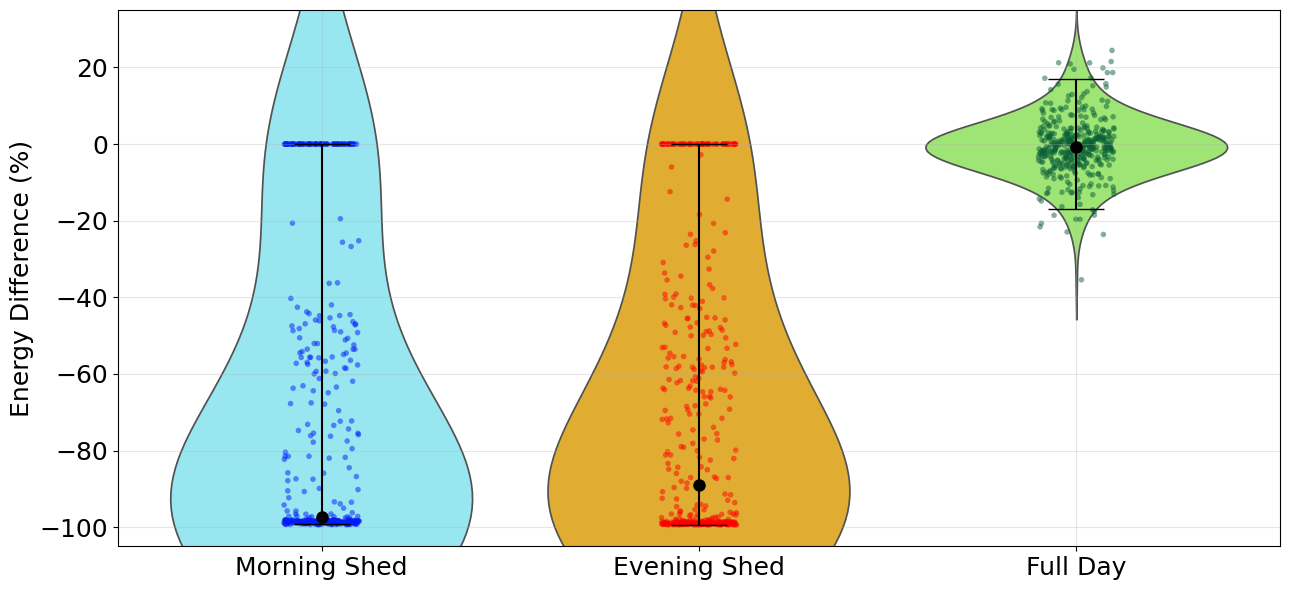

In [9]:
# -*- coding: utf-8 -*-
"""
Violin plot of Water Heating Energy %Diff
Baseline vs Control
Energy computed via time integration (kWh)
Full Day %Diff now computed over true 24h to avoid period-slicing bias.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("Processing...")

# ----------------- USER SETTINGS -----------------
A = 18
BASELINE_PARQUET = r"C:\Users\danap\OCHRE_Working\180113_1_3_BaselineLoad_Control.parquet"
CONTROL_PARQUET  = r"C:\Users\danap\OCHRE_Working\180113_1_3_EnergyShed122_Control.parquet"
POWER_COL = 'Water Heating Electric Power (kW)'

SHED_PERIODS = {
    "Morning Shed": ("06:00", 4),
    "Evening Shed": ("17:00", 3),
}

PERIOD_ORDER = ["Morning Shed", "Evening Shed", "Full Day"]

RESULTS_DIR = r"C:\Users\danap\OCHRE_Working\Figs"
FILENAME = '180113_1_3_EnergyShed_122_7_Violin.pdf'

# ----------------- LOAD DATA -----------------
df_base = pd.read_parquet(BASELINE_PARQUET)
df_ctrl = pd.read_parquet(CONTROL_PARQUET)

df_base['Time'] = pd.to_datetime(df_base['Time'])
df_ctrl['Time'] = pd.to_datetime(df_ctrl['Time'])

# ----------------- ASSIGN PERIOD -----------------
def assign_period(df):
    df = df.copy()
    df['Period'] = "Full Day"
    for period_name, (start_time, duration) in SHED_PERIODS.items():
        start = pd.to_datetime(df['Time'].dt.date.astype(str) + " " + start_time)
        end = start + pd.Timedelta(hours=duration)
        mask = (df['Time'] >= start) & (df['Time'] < end)
        df.loc[mask, 'Period'] = period_name
    return df

df_base = assign_period(df_base)
df_ctrl = assign_period(df_ctrl)

# ----------------- ENERGY INTEGRATION -----------------
def aggregate_energy(df, include_full_day=False):
    """
    Integrate energy per home per period.
    If include_full_day=True, also integrate over all 24h for Full Day.
    """
    rows = []
    for home, g_home in df.groupby('Home'):
        # Full Day integration over all hours
        if include_full_day:
            g = g_home.sort_values('Time')
            hours = (g['Time'] - g['Time'].dt.floor('D')).dt.total_seconds() / 3600
            energy_kwh = np.trapz(g[POWER_COL].values, x=hours.values)
            rows.append((home, 'Full Day', energy_kwh))
        # Per-period integration
        for period, g_period in g_home.groupby('Period'):
            if period != 'Full Day' or not include_full_day:
                g_period = g_period.sort_values('Time')
                hours = (g_period['Time'] - g_period['Time'].dt.floor('D')).dt.total_seconds() / 3600
                energy_kwh = np.trapz(g_period[POWER_COL].values, x=hours.values)
                rows.append((home, period, energy_kwh))
    return pd.DataFrame(rows, columns=['Home', 'Period', 'Energy_kWh'])

# Aggregate energies: include_full_day=True ensures full 24h integration
df_base_agg = aggregate_energy(df_base, include_full_day=True)
df_ctrl_agg = aggregate_energy(df_ctrl, include_full_day=True)

# ----------------- MERGE BASELINE + CONTROL -----------------
df_merged = pd.merge(
    df_base_agg,
    df_ctrl_agg,
    on=['Home', 'Period'],
    suffixes=('_Base', '_Control')
)

# ----------------- PER-HOME %DIFF -----------------
df_merged['%Diff'] = (df_merged['Energy_kWh_Control'] - df_merged['Energy_kWh_Base']) / df_merged['Energy_kWh_Base'] * 100

# Clip extremes for Morning/Evening sheds (97.5th percentile)
mask_shed = df_merged['Period'].isin(SHED_PERIODS.keys())
upper_bounds = df_merged[mask_shed].groupby('Period')['%Diff'].quantile(0.975).to_dict()
df_merged['%Diff_clipped'] = df_merged['%Diff']
df_merged.loc[mask_shed, '%Diff_clipped'] = df_merged[mask_shed].apply(
    lambda row: min(row['%Diff'], upper_bounds[row['Period']]), axis=1
)

# ----------------- AGGREGATED SYSTEM-WIDE %DIFF -----------------
agg_system = df_merged.groupby('Period')[['Energy_kWh_Base', 'Energy_kWh_Control']].sum()
agg_system['%Diff'] = (agg_system['Energy_kWh_Control'] - agg_system['Energy_kWh_Base']) / agg_system['Energy_kWh_Base'] * 100
print("System-wide aggregated %Diff per period:")
print(agg_system['%Diff'])

# ----------------- PER-HOME MEDIAN/MEAN & CLOSEST TO MEDIAN -----------------
median_per_period = df_merged.groupby('Period')['%Diff'].median()
mean_per_period   = df_merged.groupby('Period')['%Diff'].mean()

print("\nPer-home stats:")
for period, median_val in median_per_period.items():
    period_df = df_merged[df_merged['Period'] == period].copy()
    period_df['abs_diff'] = (period_df['%Diff'] - median_val).abs()
    closest_home = period_df.loc[period_df['abs_diff'].idxmin()]
    print(f"{period}: median ~ {median_val:.2f}%, mean ~ {mean_per_period[period]:.2f}%")
    # print(f"  Home closest to median: {closest_home['Home']} with %Diff = {closest_home['%Diff']:.2f}%")

# ----------------- SUMMARY STATS FOR PLOTTING -----------------
summary = df_merged.groupby("Period")["%Diff_clipped"].agg(
    lower=lambda x: x.quantile(0.025),
    median="median",
    upper=lambda x: x.quantile(0.975)
).reindex(PERIOD_ORDER).reset_index()

# ----------------- PLOTTING -----------------
plt.figure(figsize=(13,6))
violin_colors = ['xkcd:light grass green', 'xkcd:orangey yellow', 'xkcd:robin egg blue']
dot_colors    = ['xkcd:spruce', 'red', 'xkcd:rich blue']

sns.violinplot(
    x='Period',
    y='%Diff_clipped',
    hue='Period',
    data=df_merged,
    inner=None,
    palette=violin_colors,
    dodge=False,
    density_norm='width',
    bw_method=0.7,
    order=PERIOD_ORDER,
    legend=False
)

sns.stripplot(
    x='Period',
    y='%Diff_clipped',
    data=df_merged,
    hue='Period',
    palette=dot_colors,
    size=4,
    alpha=0.5,
    zorder=1,
    order=PERIOD_ORDER,
    legend=False
)

plt.errorbar(
    x=summary["Period"],
    y=summary["median"],
    yerr=[summary["median"] - summary["lower"], summary["upper"] - summary["median"]],
    fmt="o",
    color="black",
    capsize=20,
    elinewidth=1.5,
    markersize=8,
    zorder=100
)

plt.ylabel("Energy Difference (%)", fontsize=A)
plt.xlabel("")
plt.ylim(-105, 35)
plt.xticks(fontsize=A)
plt.yticks(fontsize=A)
plt.grid(alpha=0.3)

# Save figure
filepath = os.path.join(RESULTS_DIR, FILENAME)
# plt.savefig(filepath, format='pdf', bbox_inches='tight', pad_inches=0)
plt.tight_layout()
plt.show()


# this violin plot flags the 0Wh to 0Wh homes

Processing...

Homes with water heating load:
              total_homes  homes_with_load
Period                                    
Evening Shed          408              347
Full Day              408              408
Morning Shed          408              331

System-wide aggregated %Diff (homes with load only):
Period
Evening Shed   -71.822259
Full Day        -1.501876
Morning Shed   -77.921939
Name: %Diff, dtype: float64


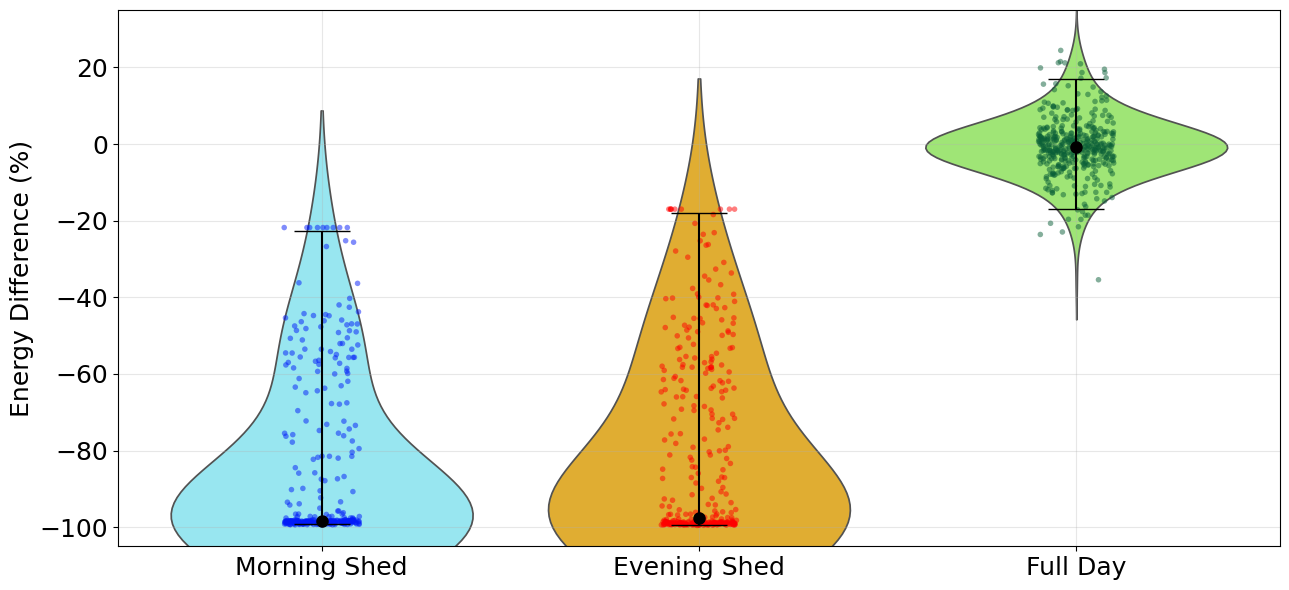

In [2]:
# -*- coding: utf-8 -*-
"""
Violin plot of Water Heating Energy %Diff
Baseline vs Control
Energy computed via time integration (kWh)
Full Day %Diff computed over true 24h
Homes with no water heating energy in both baseline and control
are excluded from all %Diff calculations.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("Processing...")

# ----------------- USER SETTINGS -----------------
A = 18
BASELINE_PARQUET = r"C:\Users\danap\OCHRE_Working\180113_1_3_BaselineLoad_Control.parquet"
CONTROL_PARQUET  = r"C:\Users\danap\OCHRE_Working\180113_1_3_EnergyShed122_Control.parquet"
POWER_COL = 'Water Heating Electric Power (kW)'

SHED_PERIODS = {
    "Morning Shed": ("06:00", 4),
    "Evening Shed": ("17:00", 3),
}

PERIOD_ORDER = ["Morning Shed", "Evening Shed", "Full Day"]

RESULTS_DIR = r"C:\Users\danap\OCHRE_Working\Figs"
FILENAME = '180113_1_3_EnergyShed_122_7_Violin.pdf'

EPS_KWH = 0.01   # 10 Wh threshold

# ----------------- LOAD DATA -----------------
df_base = pd.read_parquet(BASELINE_PARQUET)
df_ctrl = pd.read_parquet(CONTROL_PARQUET)

df_base['Time'] = pd.to_datetime(df_base['Time'])
df_ctrl['Time'] = pd.to_datetime(df_ctrl['Time'])

# ----------------- ASSIGN PERIOD -----------------
def assign_period(df):
    df = df.copy()
    df['Period'] = "Full Day"
    for period_name, (start_time, duration) in SHED_PERIODS.items():
        start = pd.to_datetime(df['Time'].dt.date.astype(str) + " " + start_time)
        end = start + pd.Timedelta(hours=duration)
        mask = (df['Time'] >= start) & (df['Time'] < end)
        df.loc[mask, 'Period'] = period_name
    return df

df_base = assign_period(df_base)
df_ctrl = assign_period(df_ctrl)

# ----------------- ENERGY INTEGRATION -----------------
def aggregate_energy(df, include_full_day=False):
    rows = []
    for home, g_home in df.groupby('Home'):
        if include_full_day:
            g = g_home.sort_values('Time')
            hours = (g['Time'] - g['Time'].dt.floor('D')).dt.total_seconds() / 3600
            energy_kwh = np.trapz(g[POWER_COL].values, x=hours.values)
            rows.append((home, 'Full Day', energy_kwh))

        for period, g_period in g_home.groupby('Period'):
            if period != 'Full Day' or not include_full_day:
                g_period = g_period.sort_values('Time')
                hours = (g_period['Time'] - g_period['Time'].dt.floor('D')).dt.total_seconds() / 3600
                energy_kwh = np.trapz(g_period[POWER_COL].values, x=hours.values)
                rows.append((home, period, energy_kwh))

    return pd.DataFrame(rows, columns=['Home', 'Period', 'Energy_kWh'])

df_base_agg = aggregate_energy(df_base, include_full_day=True)
df_ctrl_agg = aggregate_energy(df_ctrl, include_full_day=True)

# ----------------- MERGE BASELINE + CONTROL -----------------
df_merged = pd.merge(
    df_base_agg,
    df_ctrl_agg,
    on=['Home', 'Period'],
    suffixes=('_Base', '_Control')
)

# ----------------- FLAG NO-LOAD HOMES -----------------
df_merged['NoLoad'] = (
    (df_merged['Energy_kWh_Base'] < EPS_KWH) &
    (df_merged['Energy_kWh_Control'] < EPS_KWH)
)

# ----------------- REPORT PARTICIPATION -----------------
participation = df_merged.groupby('Period').agg(
    total_homes=('Home', 'count'),
    homes_with_load=('NoLoad', lambda x: (~x).sum())
)

print("\nHomes with water heating load:")
print(participation)

# ----------------- DROP NO-LOAD HOMES -----------------
df_valid = df_merged[~df_merged['NoLoad']].copy()

# ----------------- PER-HOME %DIFF -----------------
df_valid['%Diff'] = (
    (df_valid['Energy_kWh_Control'] - df_valid['Energy_kWh_Base']) /
    df_valid['Energy_kWh_Base'] * 100
)

# ----------------- CLIP EXTREMES -----------------
mask_shed = df_valid['Period'].isin(SHED_PERIODS.keys())
upper_bounds = (
    df_valid[mask_shed]
    .groupby('Period')['%Diff']
    .quantile(0.975)
    .to_dict()
)

df_valid['%Diff_clipped'] = df_valid['%Diff']
df_valid.loc[mask_shed, '%Diff_clipped'] = df_valid[mask_shed].apply(
    lambda r: min(r['%Diff'], upper_bounds[r['Period']]),
    axis=1
)

# ----------------- SYSTEM-WIDE %DIFF (VALID HOMES ONLY) -----------------
agg_system = df_valid.groupby('Period')[['Energy_kWh_Base', 'Energy_kWh_Control']].sum()
agg_system['%Diff'] = (
    (agg_system['Energy_kWh_Control'] - agg_system['Energy_kWh_Base']) /
    agg_system['Energy_kWh_Base'] * 100
)

print("\nSystem-wide aggregated %Diff (homes with load only):")
print(agg_system['%Diff'])

# ----------------- SUMMARY STATS -----------------
summary = (
    df_valid.groupby("Period")["%Diff_clipped"]
    .agg(
        lower=lambda x: x.quantile(0.025),
        median="median",
        upper=lambda x: x.quantile(0.975)
    )
    .reindex(PERIOD_ORDER)
    .reset_index()
)

# ----------------- PLOTTING -----------------
plt.figure(figsize=(13, 6))

violin_colors = ['xkcd:light grass green', 'xkcd:orangey yellow', 'xkcd:robin egg blue']
dot_colors    = ['xkcd:spruce', 'red', 'xkcd:rich blue']

sns.violinplot(
    x='Period',
    y='%Diff_clipped',
    hue='Period',
    data=df_valid,
    inner=None,
    palette=violin_colors,
    dodge=False,
    density_norm='width',
    bw_method=0.7,
    order=PERIOD_ORDER,
    legend=False
)

sns.stripplot(
    x='Period',
    y='%Diff_clipped',
    data=df_valid,
    hue='Period',
    palette=dot_colors,
    size=4,
    alpha=0.5,
    zorder=2,
    order=PERIOD_ORDER,
    legend=False
)

plt.errorbar(
    x=summary["Period"],
    y=summary["median"],
    yerr=[
        summary["median"] - summary["lower"],
        summary["upper"] - summary["median"]
    ],
    fmt="o",
    color="black",
    capsize=20,
    elinewidth=1.5,
    markersize=8,
    zorder=100
)

plt.ylabel("Energy Difference (%)", fontsize=A)
plt.xlabel("")
plt.ylim(-105, 35)
plt.xticks(fontsize=A)
plt.yticks(fontsize=A)
plt.grid(alpha=0.3)

filepath = os.path.join(RESULTS_DIR, FILENAME)
# plt.savefig(filepath, format='pdf', bbox_inches='tight', pad_inches=0)

plt.tight_layout()
plt.show()


Processing split violin for outlet temperatures...


C:\Users\danap\AppData\Local\Temp\ipykernel_18444\3631813061.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_long.groupby(["Period", "Metric"])["Temperature_F"]


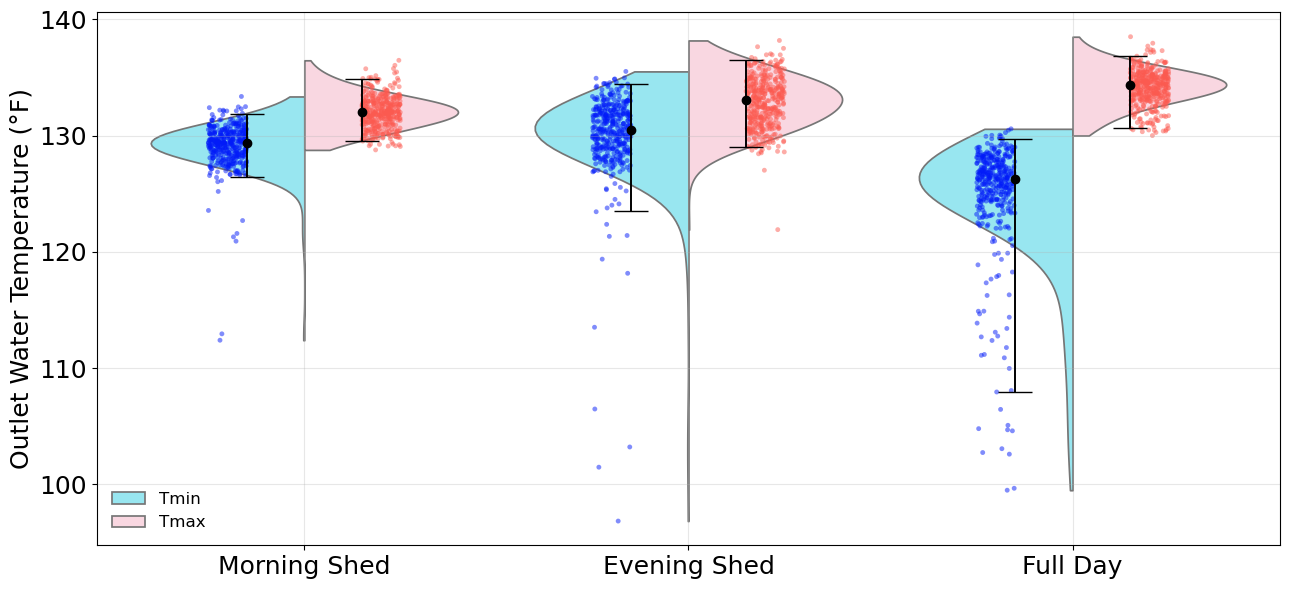

Done.


In [80]:
# -*- coding: utf-8 -*-
"""
Split violin plot of Hot Water Outlet Temperature (F)
Left = Min, Right = Max
Morning Shed, Evening Shed, Full Day
Includes median + 95% (2.5–97.5%) percentile bars
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("Processing split violin for outlet temperatures...")

# ----------------- USER SETTINGS -----------------
A = 18

BASELINE_PARQUET = r"C:\Users\danap\OCHRE_Working\180113_1_3_BaselineLoad_Control.parquet"
CONTROL_PARQUET  = r"C:\Users\danap\OCHRE_Working\180113_1_3_EnergyShed122_Control.parquet"

TIME_COL = "Time"
HOME_COL = "Home"
TEMP_COL_C = "Hot Water Outlet Temperature (C)"
TEMP_COL_F = "Hot Water Outlet Temperature (F)"

SHED_PERIODS = {
    "Morning Shed": ("06:00", 4),
    "Evening Shed": ("17:00", 3),
}

PERIOD_ORDER = ["Morning Shed", "Evening Shed", "Full Day"]

RESULTS_DIR = r"C:\Users\danap\OCHRE_Working\Figs"
FILENAME = "OutletTemp_MinMax_SplitViolin_F.pdf"

# ----------------- LOAD DATA -----------------
df = pd.read_parquet(CONTROL_PARQUET)   # CONTROL only (consistent with energy violin)
df[TIME_COL] = pd.to_datetime(df[TIME_COL])

# ----------------- CONVERT C → F -----------------
df[TEMP_COL_F] = df[TEMP_COL_C] * 9 / 5 + 32

# ----------------- ASSIGN PERIOD -----------------
def assign_period(df):
    df = df.copy()
    df["Period"] = "Full Day"

    for period_name, (start_time, duration) in SHED_PERIODS.items():
        start = pd.to_datetime(df[TIME_COL].dt.date.astype(str) + " " + start_time)
        end = start + pd.Timedelta(hours=duration)
        mask = (df[TIME_COL] >= start) & (df[TIME_COL] < end)
        df.loc[mask, "Period"] = period_name

    return df

df = assign_period(df)

# ----------------- AGGREGATE PER-HOME MIN / MAX -----------------
df_extremes = (
    df.groupby([HOME_COL, "Period"])[TEMP_COL_F]
    .agg(Temp_Min_F="min", Temp_Max_F="max")
    .reset_index()
)

# ----------------- LONG FORMAT FOR SPLIT VIOLIN -----------------
df_long = df_extremes.melt(
    id_vars=[HOME_COL, "Period"],
    value_vars=["Temp_Min_F", "Temp_Max_F"],
    var_name="Metric",
    value_name="Temperature_F"
)

df_long["Metric"] = df_long["Metric"].map({
    "Temp_Min_F": "Min",
    "Temp_Max_F": "Max"
})

df_long["Period"] = pd.Categorical(
    df_long["Period"],
    categories=PERIOD_ORDER,
    ordered=True
)

# ----------------- SUMMARY STATS (MEDIAN + 95%) -----------------
summary = (
    df_long.groupby(["Period", "Metric"])["Temperature_F"]
    .agg(
        lower=lambda x: x.quantile(0.025),
        median="median",
        upper=lambda x: x.quantile(0.975),
    )
    .reset_index()
)

# ----------------- PLOTTING -----------------
plt.figure(figsize=(13, 6))

violin_colors = {
    "Min": "xkcd:robin egg blue",
    "Max": "xkcd:light pink"
}

dot_colors = {
    "Min": "xkcd:rich blue",
    "Max": "xkcd:coral"
}

sns.violinplot(
    x="Period",
    y="Temperature_F",
    hue="Metric",
    data=df_long,
    order=PERIOD_ORDER,
    palette=violin_colors,
    split=True,
    inner=None,
    density_norm="width",
    bw_method=0.7,
    cut=0
)

sns.stripplot(
    x="Period",
    y="Temperature_F",
    hue="Metric",
    data=df_long,
    order=PERIOD_ORDER,
    palette=dot_colors,
    dodge=True,
    size=3.5,
    alpha=0.5,
    zorder=1
)

# ----------------- MEDIAN + 95% ERROR BARS -----------------
x_positions = {period: i for i, period in enumerate(PERIOD_ORDER)}
offset = 0.15

for _, row in summary.iterrows():
    base_x = x_positions[row["Period"]]
    x = base_x - offset if row["Metric"] == "Min" else base_x + offset

    plt.errorbar(
        x=x,
        y=row["median"],
        yerr=[[row["median"] - row["lower"]],
              [row["upper"] - row["median"]]],
        fmt="o",
        color="black",
        capsize=12,
        elinewidth=1.4,
        markersize=6,
        zorder=100
    )

# ----------------- LEGEND CLEANUP -----------------
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles[:2],
    ["Tmin", "Tmax"],
    fontsize=12,
    frameon=False,
    loc="lower left"
)

# ----------------- AXIS STYLING -----------------
plt.ylabel("Outlet Water Temperature (°F)", fontsize=A)
plt.xlabel("")
plt.xticks(fontsize=A)
plt.yticks(fontsize=A)
plt.grid(alpha=0.3)

plt.tight_layout()

# ----------------- SAVE -----------------
filepath = os.path.join(RESULTS_DIR, FILENAME)
# plt.savefig(filepath, format="pdf", bbox_inches="tight", pad_inches=0)

plt.show()

print("Done.")


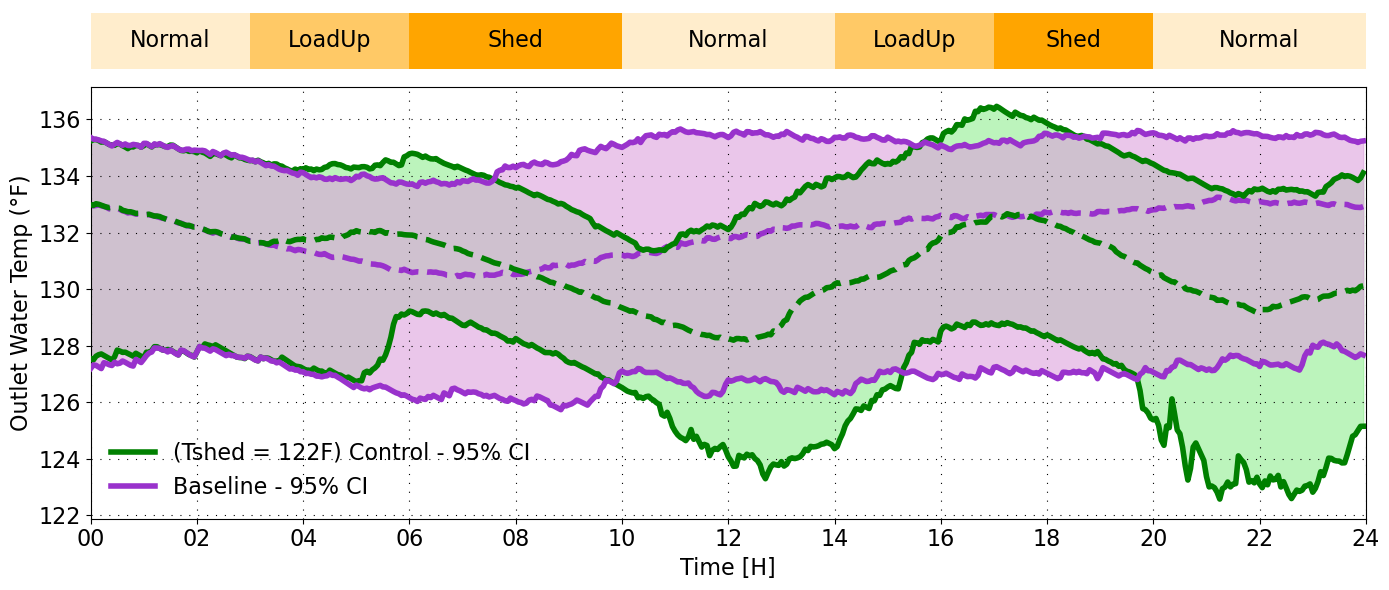

Done.


In [24]:
# -*- coding: utf-8 -*-
"""
Hot Water Outlet Temperature Time Series
Baseline vs Control
2.5th / 97.5th percentile curves with shaded range
Median plotted in green
Top horizontal bars matching previous 'bars()' style
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ----------------- USER SETTINGS -----------------
A = 16

BASELINE_PARQUET = r"C:\Users\danap\OCHRE_Working\180113_1_3_BaselineLoad_Control.parquet"
CONTROL_PARQUET  = r"C:\Users\danap\OCHRE_Working\180113_1_3_EnergyShed122_Control.parquet"
CONTROL_PARQUET2 = r"C:\Users\danap\OCHRE_Working\180113_1_3_EnergyShed122_Control.parquet"

TIME_COL = "Time"
HOME_COL = "Home"
TEMP_COL_C = "Hot Water Outlet Temperature (C)"
TEMP_COL_F = "Hot Water Outlet Temperature (F)"

# Period bar definition (sequence)
period_labels = ['Normal', 'LoadUp', 'Shed', 'Normal', 'LoadUp', 'Shed', 'Normal']
period_lengths = [3, 3, 4, 4, 3, 3, 4]  # hours

# Alpha map and colors same as previous bars()
alpha_map = {'Normal':0.2, 'LoadUp':0.6, 'Shed':1.0}
color_map = {'Normal':'orange', 'LoadUp':'orange', 'Shed':'orange'}

RESULTS_DIR = r"C:\Users\danap\OCHRE_Working\Figs"


# ----------------- HELPER FUNCTIONS -----------------
def compute_time_series_percentiles(filepath, label):
    """Compute per-time 2.5th / 97.5th percentile and median across homes"""
    df = pd.read_parquet(filepath)
    df[TIME_COL] = pd.to_datetime(df[TIME_COL])
    df[TEMP_COL_F] = df[TEMP_COL_C]*9/5 + 32
    df['Dataset'] = label
    # per-time percentiles and median
    df_ts = df.groupby(TIME_COL)[TEMP_COL_F].agg(
        P2_5=lambda x: np.percentile(x, 2.5),
        P97_5=lambda x: np.percentile(x, 97.5),
        Median='median'
    ).reset_index()
    df_ts['Dataset'] = label
    return df_ts

def compute_time_series_percentilesDB(filepath, label, deadband_F=None):
    """Compute per-time 2.5th / 97.5th percentile and median across homes.
       Optionally filter values outside a deadband (data-driven center)."""

    df = pd.read_parquet(filepath)
    df[TIME_COL] = pd.to_datetime(df[TIME_COL])
    df[TEMP_COL_F] = df[TEMP_COL_C] * 9/5 + 32
    df['Dataset'] = label

    # Apply deadband filtering ONLY if requested
    if deadband_F is not None:
        center = df[TEMP_COL_F].median()
        low = center - deadband_F
        high = center + deadband_F
        df = df[(df[TEMP_COL_F] >= low) & (df[TEMP_COL_F] <= high)]

    # Per-time aggregation (unchanged)
    df_ts = df.groupby(TIME_COL)[TEMP_COL_F].agg(
        P2_5=lambda x: np.percentile(x, 2.5) if len(x) else np.nan,
        P97_5=lambda x: np.percentile(x, 97.5) if len(x) else np.nan,
        Median='median'
    ).reset_index()

    df_ts['Dataset'] = label
    return df_ts




# ----------------- LOAD DATA -----------------
df_base_ts = compute_time_series_percentiles(BASELINE_PARQUET, 'Baseline')
df_ctrl_ts = compute_time_series_percentilesDB(CONTROL_PARQUET, 'Control', 10)
df_ctrl2_ts = compute_time_series_percentilesDB(CONTROL_PARQUET2, 'Control', 10)

# Convert time to hours
hours_ctrl = (df_ctrl_ts[TIME_COL] - df_ctrl_ts[TIME_COL].iloc[0]).dt.total_seconds()/3600
hours_ctrl2 = (df_ctrl2_ts[TIME_COL] - df_ctrl2_ts[TIME_COL].iloc[0]).dt.total_seconds()/3600
hours_base = (df_base_ts[TIME_COL] - df_base_ts[TIME_COL].iloc[0]).dt.total_seconds()/3600

# ----------------- CREATE FIGURE -----------------
fig, (ax_bar, ax_ts) = plt.subplots(2,1, figsize=(14,6), gridspec_kw={'height_ratios':[1,7]}, sharex=True)

fig.subplots_adjust(hspace=0.05)

# ----------------- TOP HORIZONTAL PERIOD BARS -----------------
labels = ['']  # dummy, single row
data = np.array([period_lengths])  # 2D array for barh
data_cum = data.cumsum(axis=1)
Alpha = [alpha_map[label] for label in period_labels]

# Draw each segment exactly like bars()
for i, width in enumerate(data[0]):
    start = data_cum[0,i] - width
    ax_bar.barh(y=0, width=width, left=start, color=color_map[period_labels[i]],
                edgecolor='none', alpha=Alpha[i])
    ax_bar.text(start + width/2, 0, period_labels[i], ha='center', va='center', fontsize=A, color='black')

ax_bar.invert_yaxis()
ax_bar.axis('off')
ax_bar.set_xlim(0, sum(period_lengths))

# ----------------- PLOT CONTROL AND BASELINE CURVES -----------------
# # Control percentiles
# ax_ts.plot(hours_ctrl, df_ctrl_ts['P2_5'], linestyle='-', color='xkcd:blue', label='(Tshed = 125F) Control - 95% CI', zorder=5, linewidth=3)
# ax_ts.plot(hours_ctrl, df_ctrl_ts['P97_5'], linestyle='-', color='xkcd:blue', zorder=5, linewidth=3)
# ax_ts.fill_between(hours_ctrl, df_ctrl_ts['P2_5'], df_ctrl_ts['P97_5'], color='xkcd:lightblue', alpha=0.3)
# ax_ts.plot(hours_ctrl, df_ctrl_ts['Median'], linestyle='--', color='blue', zorder=10, linewidth=3)

# # Control2 percentiles
# ax_ts.plot(hours_ctrl2, df_ctrl2_ts['P2_5'], linestyle='-', color='xkcd:green', label='(Tshed = 105F) Control - 95% CI', zorder=5, linewidth=3)
# ax_ts.plot(hours_ctrl2, df_ctrl2_ts['P97_5'], linestyle='-', color='xkcd:green', zorder=5, linewidth=3)
# ax_ts.fill_between(hours_ctrl2, df_ctrl2_ts['P2_5'], df_ctrl2_ts['P97_5'], color='xkcd:lightgreen', alpha=0.3)
# ax_ts.plot(hours_ctrl2, df_ctrl2_ts['Median'], linestyle='--', color='green', zorder=10, linewidth=3)

# # Baseline percentiles
# ax_ts.plot(hours_base, df_base_ts['P2_5'], linestyle='-', color='xkcd:red', label='Baseline - 95% CI', zorder=10, linewidth=3)
# ax_ts.plot(hours_base, df_base_ts['P97_5'], linestyle='-', color='xkcd:red', zorder=10, linewidth=3)
# ax_ts.fill_between(hours_base, df_base_ts['P2_5'], df_base_ts['P97_5'], color='xkcd:coral', alpha=0.2)
# ax_ts.plot(hours_base, df_base_ts['Median'], linestyle='--', color='xkcd:red',  zorder=15, linewidth=3)


# # Control percentiles
# ax_ts.plot(hours_ctrl, df_ctrl_ts['P2_5'], linestyle='-', color='darkorange', label='(Tshed = 125F) Control - 95% CI', zorder=5, linewidth=4)
# ax_ts.plot(hours_ctrl, df_ctrl_ts['P97_5'], linestyle='-', color='darkorange', zorder=5, linewidth=4)
# ax_ts.fill_between(hours_ctrl, df_ctrl_ts['P2_5'], df_ctrl_ts['P97_5'], color='gold', alpha=1)
# ax_ts.plot(hours_ctrl, df_ctrl_ts['Median'], linestyle='--', color='darkorange', zorder=100, linewidth=4)

# Control2 percentiles
ax_ts.plot(hours_ctrl2, df_ctrl2_ts['P2_5'], linestyle='-', color='green', label='(Tshed = 122F) Control - 95% CI', zorder=5, linewidth=4)
ax_ts.plot(hours_ctrl2, df_ctrl2_ts['P97_5'], linestyle='-', color='green', zorder=5, linewidth=4)
ax_ts.fill_between(hours_ctrl2, df_ctrl2_ts['P2_5'], df_ctrl2_ts['P97_5'], color='lightgreen', alpha=0.6)
ax_ts.plot(hours_ctrl2, df_ctrl2_ts['Median'], linestyle='--', color='green', zorder=10, linewidth=4)

# Baseline percentiles
ax_ts.plot(hours_base, df_base_ts['P2_5'], linestyle='-', color='darkorchid', label='Baseline - 95% CI', zorder=10, linewidth=4)
ax_ts.plot(hours_base, df_base_ts['P97_5'], linestyle='-', color='darkorchid', zorder=10, linewidth=4)
ax_ts.fill_between(hours_base, df_base_ts['P2_5'], df_base_ts['P97_5'], color='plum', alpha=0.6)
ax_ts.plot(hours_base, df_base_ts['Median'], linestyle='--', color='darkorchid',  zorder=1, linewidth=4)


# ----------------- AXES FORMATTING -----------------
ax_ts.set_xlim(0,24)
ax_ts.set_xticks(range(0,25,2))
ax_ts.set_xticklabels([f"{h:02d}" for h in range(0,25,2)], fontsize=A)
ax_ts.set_ylabel("Outlet Water Temp (°F)", fontsize=A)
ax_ts.set_xlabel("Time [H]", fontsize=A)
ax_ts.tick_params(axis='y', labelsize=A)
ax_ts.grid(True, linestyle=(0,(1,7)), color='black', linewidth=0.8)
ax_ts.legend(
    fontsize=A, 
    loc='lower left',        # anchor point of the legend
    bbox_to_anchor=(0.0, 0),  # x, y offset in axes fraction
    frameon=False
)

from matplotlib.ticker import FuncFormatter

# After plotting, but before plt.show():
ax_ts.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}'))

plt.tight_layout()


# ----------------- SAVE -----------------
FILENAME = "180113_1_3_EnergyShed122_95CI.pdf"
filepath = os.path.join(RESULTS_DIR, FILENAME)
# plt.savefig(filepath, format='pdf', bbox_inches='tight', pad_inches=0)

plt.show()
print("Done.")


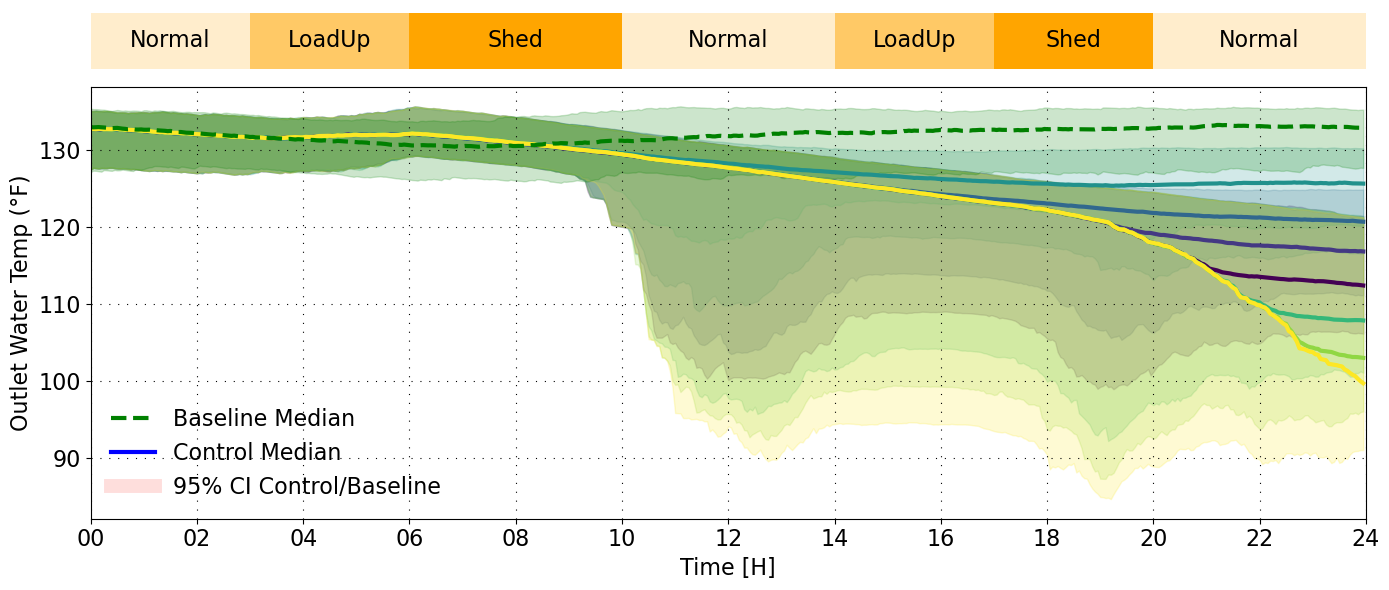

All controls and baseline plotted on the same figure.


In [121]:
# -*- coding: utf-8 -*-
"""
Overlay multiple control files and baseline
Hot Water Outlet Temperature (F)
2.5th / 97.5th percentile shaded, median line, top horizontal bars
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D

# ----------------- USER SETTINGS -----------------
A = 16
WORKING_DIR = r"C:\Users\danap\OCHRE_Working"

CONTROL_FILES = [
    "180110_1_3_ShedLong110_Control.parquet",
    "180110_1_3_ShedLong115_Control.parquet",
    "180110_1_3_ShedLong120_Control.parquet",
    "180110_1_3_ShedLong125_Control.parquet",
    "180110_1_3_ShedLong105_Control.parquet",
    "180110_1_3_ShedLong100_Control.parquet",
    "180110_1_3_ShedLong95_Control.parquet",
]

BASELINE_FILE = "180113_1_3_BaselineLoad_Control.parquet"

TIME_COL = "Time"
TEMP_COL_C = "Hot Water Outlet Temperature (C)"
TEMP_COL_F = "Hot Water Outlet Temperature (F)"

# Period bar definition (sequence)
period_labels = ['Normal', 'LoadUp', 'Shed', 'Normal', 'LoadUp', 'Shed', 'Normal']
period_lengths = [3, 3, 4, 4, 3, 3, 4]  # hours
alpha_map = {'Normal':0.2, 'LoadUp':0.6, 'Shed':1.0}
color_map = {'Normal':'orange', 'LoadUp':'orange', 'Shed':'orange'}

RESULTS_DIR = r"C:\Users\danap\OCHRE_Working\Figs"
FILENAME = "AllControls_OutletTemp_TimeSeries.pdf"

# ----------------- HELPER FUNCTION -----------------
def compute_temp_percentiles(filepath, label):
    df = pd.read_parquet(filepath)
    df[TIME_COL] = pd.to_datetime(df[TIME_COL])
    df[TEMP_COL_F] = df[TEMP_COL_C]*9/5 + 32
    df_ts = df.groupby(TIME_COL)[TEMP_COL_F].agg(
        P2_5=lambda x: np.percentile(x, 2.5),
        P97_5=lambda x: np.percentile(x, 97.5),
        Median='median'
    ).reset_index()
    df_ts['Dataset'] = label
    return df_ts

# ----------------- LOAD BASELINE -----------------
baseline_ts = compute_temp_percentiles(os.path.join(WORKING_DIR, BASELINE_FILE), 'Baseline')
hours_base = (baseline_ts[TIME_COL] - baseline_ts[TIME_COL].iloc[0]).dt.total_seconds()/3600

# ----------------- CREATE FIGURE -----------------
fig, (ax_bar, ax_ts) = plt.subplots(2,1, figsize=(14,6), gridspec_kw={'height_ratios':[1,7]}, sharex=True)

# Top period bars
data = np.array([period_lengths])
data_cum = data.cumsum(axis=1)
Alpha = [alpha_map[l] for l in period_labels]
for i, width in enumerate(data[0]):
    start = data_cum[0,i] - width
    ax_bar.barh(y=0, width=width, left=start, color=color_map[period_labels[i]],
                edgecolor='none', alpha=Alpha[i])
    ax_bar.text(start + width/2, 0, period_labels[i], ha='center', va='center', fontsize=A, color='black')
ax_bar.invert_yaxis()
ax_bar.axis('off')
ax_bar.set_xlim(0, sum(period_lengths))

# ----------------- PLOT CONTROL FILES -----------------
colors_ctrl = plt.cm.viridis(np.linspace(0,1,len(CONTROL_FILES)))  # different colors for each control
for i, cf in enumerate(CONTROL_FILES):
    label = os.path.splitext(cf)[0]
    df_ts = compute_temp_percentiles(os.path.join(WORKING_DIR, cf), label)
    hours_ctrl = (df_ts[TIME_COL] - df_ts[TIME_COL].iloc[0]).dt.total_seconds()/3600

    # shaded CI
    ax_ts.fill_between(hours_ctrl, df_ts['P2_5'], df_ts['P97_5'], color=colors_ctrl[i], alpha=0.2)
    # median line
    ax_ts.plot(hours_ctrl, df_ts['Median'], color=colors_ctrl[i], linestyle='-', linewidth=3, label=f'{label} Median')

# ----------------- PLOT BASELINE -----------------
ax_ts.fill_between(hours_base, baseline_ts['P2_5'], baseline_ts['P97_5'], color='green', alpha=0.2)
ax_ts.plot(hours_base, baseline_ts['Median'], color='green', linestyle='--', linewidth=3, label='Baseline Median')

# ----------------- AXES FORMATTING -----------------
ax_ts.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}'))
ax_ts.set_xlim(0,24)
ax_ts.set_xticks(range(0,25,2))
ax_ts.set_xticklabels([f"{h:02d}" for h in range(0,25,2)], fontsize=A)
ax_ts.set_ylabel("Outlet Water Temp (°F)", fontsize=A)
ax_ts.set_xlabel("Time [H]", fontsize=A)
ax_ts.tick_params(axis='y', labelsize=A)
ax_ts.grid(True, linestyle=(0,(1,7)), color='black', linewidth=0.8)

# ----------------- CUSTOM LEGEND -----------------
# legend_handles = [
#     Line2D([0],[0], color='green', linewidth=3, linestyle='--', label='Baseline Median'),
#     Line2D([0],[0], color='blue', linewidth=3, linestyle='-', label='Control Median'),
#     Line2D([0],[0], color='xkcd:coral', linewidth=10, alpha=0.2, label='95% CI Control/Baseline')
# ]
ax_ts.legend(handles=legend_handles, fontsize=A, loc='lower left', frameon=False)

plt.tight_layout()

# ----------------- SAVE -----------------
filepath_out = os.path.join(RESULTS_DIR, FILENAME)
# plt.savefig(filepath_out, format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()

print("All controls and baseline plotted on the same figure.")


In [2]:
M_LU_weights = [14, 28, 34, 41, 46, 46, 41, 33, 30, 31, 35, 30]
x = 0

for i in M_LU_weights:
    x += i

print(len(M_LU_weights))
print(x)    

12

KeyboardInterrupt: 

409

KeyboardInterrupt: 

In [25]:
import pandas as pd
import glob
import os

# ---------------- USER SETTINGS ----------------
ROOT_DIR = r"C:\Users\danap\OCHRE_Working\Input Files"
FILE_NAME = "HPWH Controlled.csv"

DRAW_COL = "Hot Water Delivered (L/min)"

# Simulation timestep (minutes) — SET THIS CORRECTLY
T_RES_MIN = 3

OUTPUT_PARQUET = r"C:\Users\danap\OCHRE_Working\All_Homes_HotWater_Draw.parquet"

# ---------------- FIND FILES ----------------
files = glob.glob(os.path.join(ROOT_DIR, "bldg*", FILE_NAME))

if not files:
    raise FileNotFoundError("No HPWH Controlled.csv files found")

print(f"Found {len(files)} buildings")

# ---------------- PROCESS FILES ----------------
records = []

for f in files:
    df = pd.read_csv(f)

    if DRAW_COL not in df.columns:
        print(f"⚠️ Missing '{DRAW_COL}' in {f}")
        continue

    # Building name = folder name
    bldg_name = os.path.basename(os.path.dirname(f))

    # Convert L/min → L per timestep
    df["Draw_L"] = df[DRAW_COL] * T_RES_MIN

    records.append({
        "Building": bldg_name,
        "Total_Draw_L": df["Draw_L"].sum(),
        "Total_Draw_gal": df["Draw_L"].sum() / 3.785,
        "Mean_Draw_L_per_min": df[DRAW_COL].mean(),
        "Peak_Draw_L_per_min": df[DRAW_COL].max()
    })

# ---------------- CREATE DATAFRAME ----------------
df_summary = pd.DataFrame(records)

df_summary = df_summary.sort_values("Total_Draw_gal", ascending=False)

# ---------------- SAVE PARQUET ----------------
df_summary.to_parquet(OUTPUT_PARQUET, index=False)

print("✅ Hot water aggregation complete")
print(df_summary.describe())
print(f"Saved parquet: {OUTPUT_PARQUET}")


Found 408 buildings
✅ Hot water aggregation complete
       Total_Draw_L  Total_Draw_gal  Mean_Draw_L_per_min  Peak_Draw_L_per_min
count    408.000000      408.000000           408.000000           408.000000
mean     308.061268       81.390031             0.106966             1.229158
std      200.937746       53.087912             0.069770             0.632514
min       31.831631        8.409942             0.011053             0.341771
25%      162.624451       42.965509             0.056467             0.780230
50%      257.337929       67.988885             0.089353             1.084620
75%      385.966813      101.972738             0.134016             1.551588
max     1329.990958      351.384665             0.461802             4.238075
Saved parquet: C:\Users\danap\OCHRE_Working\All_Homes_HotWater_Draw.parquet


In [1]:
import pandas as pd

PARQUET_FILE = r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed110_Control.parquet"

df = pd.read_parquet(PARQUET_FILE)

# Print first 20 rows of the 'home' column
# print(df['Home'].head(20))


In [46]:
import pandas as pd
import glob
import os

# ---------------- SETTINGS ----------------
# Parquet file with homes
PARQUET_FILE = r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed110_Control.parquet"

# Folder(s) with per-home HPWH Controlled CSVs
INPUT_DIR = r"C:\Users\danap\OCHRE_Working\Input Files"
CSV_PATTERN = os.path.join(INPUT_DIR, "bldg*", "HPWH Controlled.csv")

# Simulation timestep (minutes)
T_RES_MIN = 1

# Output CSV
OUTPUT_FILE = r"C:\Users\danap\OCHRE_Working\Homes_HotWater_Use.csv"

# ---------------- LOAD HOMES ----------------
df_homes = pd.read_parquet(PARQUET_FILE)
homes = df_homes['Home'].unique()  # unique home IDs

# ---------------- PROCESS HOT WATER CSVs ----------------
files = glob.glob(CSV_PATTERN)
records = []

for f in files:
    df_csv = pd.read_csv(f)
    
    if 'Hot Water Delivered (L/min)' not in df_csv.columns:
        print(f"⚠️ Missing draw column in {f}")
        continue

    # Building name or home ID (depends on your CSV structure)
    if 'Home' in df_csv.columns:
        home_ids = df_csv['Home'].unique()
    else:
        # fallback: infer from folder
        home_ids = [os.path.basename(os.path.dirname(f))]
    
    for home in home_ids:
        # Filter data for this home
        df_home = df_csv[df_csv['Home'] == home] if 'Home' in df_csv.columns else df_csv
        
        # Convert L/min → L per timestep
        df_home['Draw_L'] = df_home['Hot Water Delivered (L/min)'] * T_RES_MIN
        
        total_L = df_home['Draw_L'].sum()
        total_gal = total_L / 3.785  # convert to gallons
        
        records.append({
            'Home': home,
            'Total_Draw_L': total_L,
            'Total_Draw_gal': total_gal
        })

# ---------------- CREATE DATAFRAME ----------------
df_draw = pd.DataFrame(records)

# ---------------- MERGE WITH HOMES ----------------
df_merged = pd.DataFrame({'Home': homes}).merge(df_draw, on='Home', how='left')

# ---------------- SAVE ----------------
df_merged.to_csv(OUTPUT_FILE, index=False)
print(f"✅ Saved merged home hot water use: {OUTPUT_FILE}")
print(df_merged.head(20))


✅ Saved merged home hot water use: C:\Users\danap\OCHRE_Working\Homes_HotWater_Use.csv
                Home  Total_Draw_L  Total_Draw_gal
0   bldg0002631-up06    148.371320       39.199820
1   bldg0007434-up06     78.639916       20.776728
2   bldg0007856-up06    151.938774       40.142345
3   bldg0008020-up06     41.037085       10.842031
4   bldg0008194-up06    159.926787       42.252784
5   bldg0008526-up06     62.304419       16.460877
6   bldg0010483-up06    204.061634       53.913245
7   bldg0011355-up06     21.925336        5.792691
8   bldg0012517-up06     43.757303       11.560714
9   bldg0012639-up06     75.797329       20.025715
10  bldg0013091-up06    210.512279       55.617511
11  bldg0013304-up06    127.523094       33.691702
12  bldg0014112-up06     56.622219       14.959635
13  bldg0014537-up06     36.627453        9.677002
14  bldg0014628-up06     72.712836       19.210789
15  bldg0016331-up06    121.653656       32.140992
16  bldg0019171-up06     50.354538       13.30

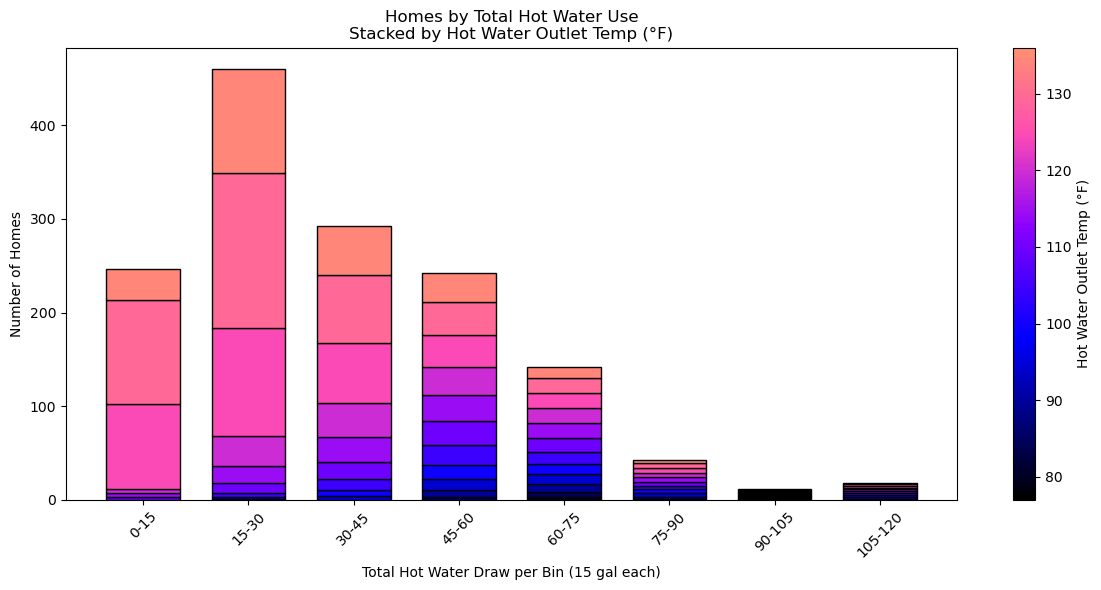

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# ---------------- FILES ----------------
DRAW_FILE = r"C:\Users\danap\OCHRE_Working\Homes_HotWater_Use.csv"
BASELINE_PARQUET = r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed110_Control.parquet"

# ---------------- LOAD DATA ----------------
df_draw = pd.read_csv(DRAW_FILE)  # Home, Total_Draw_gal
df_temp = pd.read_parquet(BASELINE_PARQUET)  # baseline temperatures

# ---------------- FILTER DEAD BAND ----------------
target_deadband = round(8.3333, 2)
df_temp = df_temp[np.round(df_temp['Deadband_C'], 2) == target_deadband]

# ---------------- COMPUTE PER-HOME 2.5/50/97.5 ----------------
TEMP_COL = "Hot Water Outlet Temperature (C)"
df_temp['Temp_F'] = df_temp[TEMP_COL] * 9/5 + 32

df_stats = df_temp.groupby('Home')['Temp_F'].agg(
    Temp_2_5=lambda x: np.percentile(x, 2.5),
    Temp_50=lambda x: np.percentile(x, 50),
    Temp_97_5=lambda x: np.percentile(x, 97.5)
).reset_index()

# ---------------- MERGE WITH TOTAL DRAW ----------------
df = df_draw.merge(df_stats, on='Home', how='inner')

# ---------------- TOTAL DRAW BINS ----------------
BIN_WIDTH = 15  # gallons per bin
min_draw = 0
max_draw = np.ceil(df['Total_Draw_gal'].max()/BIN_WIDTH)*BIN_WIDTH
bins = np.arange(min_draw, max_draw+BIN_WIDTH, BIN_WIDTH)
df['Draw_Bin'] = pd.cut(df['Total_Draw_gal'], bins=bins, labels=False, include_lowest=True)

# ---------------- TEMPERATURE QUANTIZATION ----------------
# Adjust quantization for the bars (low -> mid -> high)
TEMP_BIN_WIDTH = 5  # degrees F per rectangle
temp_min = int(df[['Temp_2_5','Temp_50','Temp_97_5']].min().min())
temp_max = int(df[['Temp_2_5','Temp_50','Temp_97_5']].max().max())
temp_bins = np.arange(temp_min, temp_max + TEMP_BIN_WIDTH, TEMP_BIN_WIDTH)

# ---------------- CREATE STACKED COUNTS ----------------
draw_bins = df['Draw_Bin'].unique()
draw_bins.sort()
stack_counts = []

for b in draw_bins:
    df_bin = df[df['Draw_Bin']==b]
    counts = []
    for i in range(len(temp_bins)-1):
        # Count homes whose 2.5/50/97.5 overlaps this temp bin
        mask = ((df_bin['Temp_2_5'] <= temp_bins[i+1]) & (df_bin['Temp_97_5'] >= temp_bins[i]))
        counts.append(mask.sum())
    stack_counts.append(counts)

stack_counts = np.array(stack_counts)  # rows = draw bins, cols = temp bins

# ---------------- CUSTOM TRUNCATED COLORMAP ----------------
cmap = plt.colormaps['gnuplot2']
cmap_trunc = LinearSegmentedColormap.from_list('gnuplot2_trunc', cmap(np.linspace(0, 0.7, 256)))
norm = plt.Normalize(vmin=temp_min, vmax=temp_max)
colors = [cmap_trunc(norm((temp_bins[i]+temp_bins[i+1])/2)) for i in range(len(temp_bins)-1)]

# ---------------- PLOT ----------------
fig, ax = plt.subplots(figsize=(12,6))
x = np.arange(len(draw_bins))
bottom = np.zeros(len(draw_bins))

for i, color in enumerate(colors):
    ax.bar(x, stack_counts[:,i], bottom=bottom, color=color, width=0.7, edgecolor='black')
    bottom += stack_counts[:,i]

# X-axis labels
bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
ax.set_xticks(x)
ax.set_xticklabels(bin_labels, rotation=45)

ax.set_ylabel('Number of Homes')
ax.set_xlabel(f'Total Hot Water Draw per Bin ({BIN_WIDTH} gal each)')
ax.set_title('Homes by Total Hot Water Use\nStacked by Hot Water Outlet Temp (°F)')

# ---------------- COLORBAR ----------------
sm = plt.cm.ScalarMappable(cmap=cmap_trunc, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Hot Water Outlet Temp (°F)')

plt.tight_layout()
plt.show()


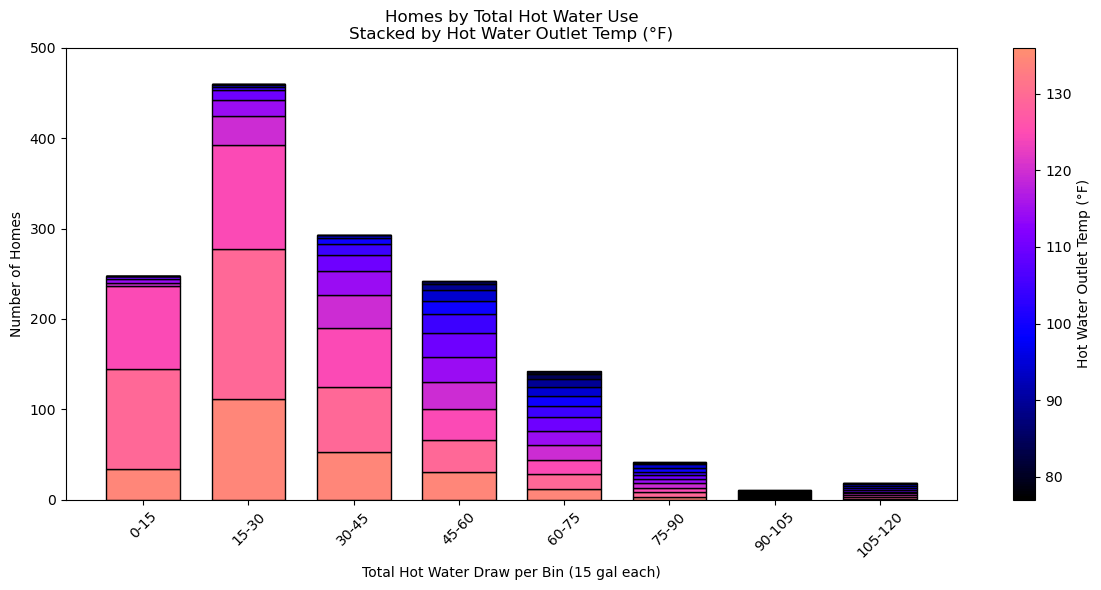

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter

# ---------------- FILES ----------------
DRAW_FILE = r"C:\Users\danap\OCHRE_Working\Homes_HotWater_Use.csv"
BASELINE_PARQUET = r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed110_Control.parquet"

# ---------------- LOAD DATA ----------------
df_draw = pd.read_csv(DRAW_FILE)  # Home, Total_Draw_gal
df_temp = pd.read_parquet(BASELINE_PARQUET)  # baseline temperatures

# ---------------- FILTER DEAD BAND ----------------
target_deadband = round(8.3333, 2)
df_temp = df_temp[np.round(df_temp['Deadband_C'], 2) == target_deadband]

# ---------------- TEMPERATURE QUANTIZATION ----------------
TEMP_BIN_WIDTH = 5  # degrees F per rectangle
df_temp['Temp_F'] = df_temp["Hot Water Outlet Temperature (C)"] * 9/5 + 32

# Merge with total draw
df = df_draw.merge(
    df_temp.groupby('Home')['Temp_F'].agg(
        Temp_2_5=lambda x: np.percentile(x, 2.5),
        Temp_50=lambda x: np.percentile(x, 50),
        Temp_97_5=lambda x: np.percentile(x, 97.5)
    ).reset_index(),
    on='Home', how='inner'
)

# Total draw bins
BIN_WIDTH = 15
min_draw = 0
max_draw = np.ceil(df['Total_Draw_gal'].max()/BIN_WIDTH)*BIN_WIDTH
bins = np.arange(min_draw, max_draw + BIN_WIDTH, BIN_WIDTH)
df['Draw_Bin'] = pd.cut(df['Total_Draw_gal'], bins=bins, labels=False, include_lowest=True)

# Temperature bins for stacking
temp_min = int(df[['Temp_2_5','Temp_50','Temp_97_5']].min().min())
temp_max = int(df[['Temp_2_5','Temp_50','Temp_97_5']].max().max())
temp_bins = np.arange(temp_min, temp_max + TEMP_BIN_WIDTH, TEMP_BIN_WIDTH)

# ---------------- STACKED COUNTS ----------------
draw_bins = df['Draw_Bin'].unique()
draw_bins.sort()
stack_counts = []

for b in draw_bins:
    df_bin = df[df['Draw_Bin']==b]
    counts = []
    for i in range(len(temp_bins)-1):
        mask = ((df_bin['Temp_2_5'] <= temp_bins[i+1]) & (df_bin['Temp_97_5'] >= temp_bins[i]))
        counts.append(mask.sum())
    stack_counts.append(counts)

stack_counts = np.array(stack_counts)

# ---------------- COLORMAP ----------------
cmap = plt.colormaps['gnuplot2']
cmap_trunc = LinearSegmentedColormap.from_list('gnuplot2_trunc', cmap(np.linspace(0, 0.7, 256)))
norm = plt.Normalize(vmin=temp_min, vmax=temp_max)
colors = [cmap_trunc(norm((temp_bins[i]+temp_bins[i+1])/2)) for i in range(len(temp_bins)-1)]

# ---------------- PLOT ----------------
# fig, ax = plt.subplots(figsize=(12,6))
# x = np.arange(len(draw_bins))
# bottom = np.zeros(len(draw_bins))

# for i, color in enumerate(colors):
#     ax.bar(x, stack_counts[:,i], bottom=bottom, color=color, width=0.7, edgecolor='black')
#     bottom += stack_counts[:,i]

# ---------------- PLOT (colder on top, warmer on bottom) ----------------
fig, ax = plt.subplots(figsize=(12,6))
x = np.arange(len(draw_bins))
bottom = np.zeros(len(draw_bins))

# reverse the order of colors and stacks
for i, color in reversed(list(enumerate(colors))):
    ax.bar(x, stack_counts[:,i], bottom=bottom, color=color, width=0.7, edgecolor='black')
    bottom += stack_counts[:,i]


# ---------------- X-AXIS LABELS ----------------
bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
ax.set_xticks(x)
ax.set_xticklabels(bin_labels, rotation=45)

# ---------------- Y-AXIS LOG SCALE ----------------
ax.set_yscale('linear')
# ax.yaxis.set_major_formatter(ScalarFormatter())  # force regular numbers instead of 10^x
ax.set_ylim(0, 500)  # avoid log(0) error

ax.set_ylabel('Number of Homes')
ax.set_xlabel(f'Total Hot Water Draw per Bin ({BIN_WIDTH} gal each)')
ax.set_title('Homes by Total Hot Water Use\nStacked by Hot Water Outlet Temp (°F)')

# ---------------- COLORBAR ----------------
sm = plt.cm.ScalarMappable(cmap=cmap_trunc, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Hot Water Outlet Temp (°F)')

plt.tight_layout()
plt.show()


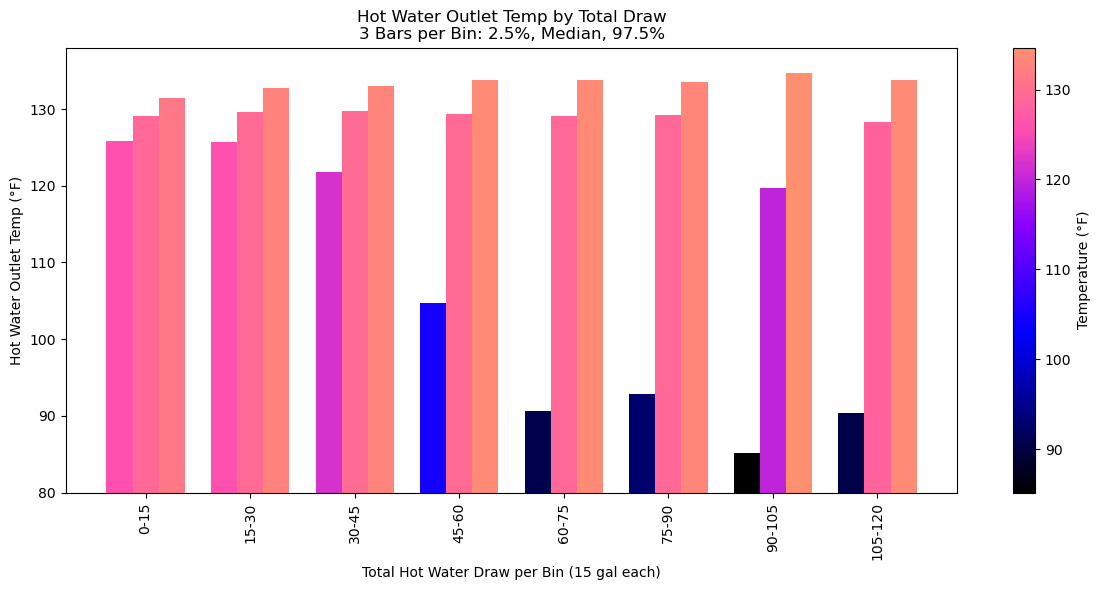

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# ---------------- FILES ----------------
DRAW_FILE = r"C:\Users\danap\OCHRE_Working\Homes_HotWater_Use.csv"
BASELINE_PARQUET = r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed110_Control.parquet"

# ---------------- LOAD DATA ----------------
df_draw = pd.read_csv(DRAW_FILE)  # Home, Total_Draw_gal
df_temp = pd.read_parquet(BASELINE_PARQUET)  # baseline temperatures

# ---------------- FILTER DEAD BAND ----------------
target_deadband = round(8.3333, 2)
df_temp = df_temp[np.round(df_temp['Deadband_C'], 2) == target_deadband]

# ---------------- COMPUTE PER-HOME 2.5/50/97.5 ----------------
TEMP_COL = "Hot Water Outlet Temperature (C)"
df_temp['Temp_F'] = df_temp[TEMP_COL] * 9/5 + 32

df_stats = df_temp.groupby('Home')['Temp_F'].agg(
    Temp_2_5=lambda x: np.percentile(x, 2.5),
    Temp_50=lambda x: np.percentile(x, 50),
    Temp_97_5=lambda x: np.percentile(x, 97.5)
).reset_index()

# ---------------- MERGE WITH TOTAL DRAW ----------------
df = df_draw.merge(df_stats, on='Home', how='inner')

# ---------------- TOTAL DRAW BINS ----------------
BIN_WIDTH = 15  # gallons per bin
min_draw = 0
max_draw = np.ceil(df['Total_Draw_gal'].max()/BIN_WIDTH)*BIN_WIDTH
bins = np.arange(min_draw, max_draw+BIN_WIDTH, BIN_WIDTH)
df['Draw_Bin'] = pd.cut(df['Total_Draw_gal'], bins=bins, labels=False, include_lowest=True)

# ---------------- PER-BIN PERCENTILE MEDIANS ----------------
bin_stats = df.groupby('Draw_Bin').agg({
    'Temp_2_5':'median',
    'Temp_50':'median',
    'Temp_97_5':'median',
    'Home':'count'
}).reset_index()

# ---------------- PLOTTING ----------------
fig, ax = plt.subplots(figsize=(12,6))
x = np.arange(len(bin_stats))  # x positions for draw bins
width = 0.25  # width of each bar

# ---------------- COLOR MAP ----------------
cmap = plt.colormaps['gnuplot2']
cmap_trunc = LinearSegmentedColormap.from_list('gnuplot2_trunc', cmap(np.linspace(0, 0.7, 256)))

# normalize by temp for colors
temp_min = bin_stats[['Temp_2_5','Temp_50','Temp_97_5']].min().min()
temp_max = bin_stats[['Temp_2_5','Temp_50','Temp_97_5']].max().max()
norm = plt.Normalize(vmin=temp_min, vmax=temp_max)

# Plot three bars per bin
ax.bar(x - width, bin_stats['Temp_2_5'], width, color=cmap_trunc(norm(bin_stats['Temp_2_5'])), label='2.5th percentile')
ax.bar(x,         bin_stats['Temp_50'], width, color=cmap_trunc(norm(bin_stats['Temp_50'])), label='Median')
ax.bar(x + width, bin_stats['Temp_97_5'], width, color=cmap_trunc(norm(bin_stats['Temp_97_5'])), label='97.5th percentile')

# X-axis labels
# only label bins that are in bin_stats
bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in bin_stats['Draw_Bin']]
ax.set_xticks(x)
ax.set_xticklabels(bin_labels, rotation=90)

ax.set_ylabel('Hot Water Outlet Temp (°F)')
ax.set_xlabel(f'Total Hot Water Draw per Bin ({BIN_WIDTH} gal each)')
ax.set_title('Hot Water Outlet Temp by Total Draw\n3 Bars per Bin: 2.5%, Median, 97.5%')
ax.set_ylim(80, 138)


# ---------------- COLORBAR ----------------
sm = plt.cm.ScalarMappable(cmap=cmap_trunc, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Temperature (°F)')

plt.tight_layout()
plt.show()


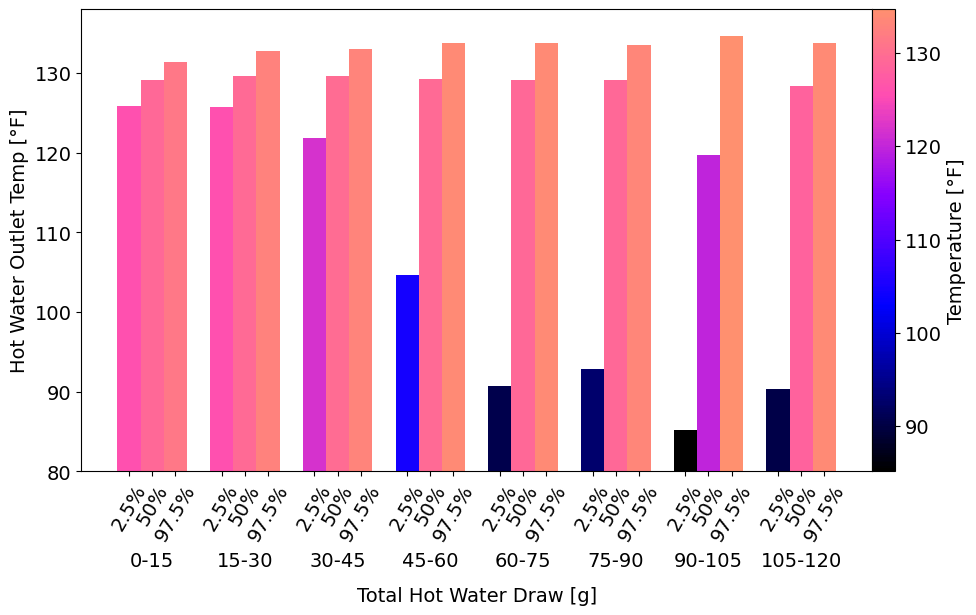

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# ---------------- UNIVERSAL FONT SIZE ----------------
A = 14  # set this once, all labels/ticks will use it

# ---------------- FILES ----------------
DRAW_FILE = r"C:\Users\danap\OCHRE_Working\Homes_HotWater_Use.csv"
BASELINE_PARQUET = r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed110_Control.parquet"

# ---------------- LOAD DATA ----------------
df_draw = pd.read_csv(DRAW_FILE)  # Home, Total_Draw_gal
df_temp = pd.read_parquet(BASELINE_PARQUET)  # baseline temperatures

# ---------------- FILTER DEAD BAND ----------------
target_deadband = round(8.3333, 2)
df_temp = df_temp[np.round(df_temp['Deadband_C'], 2) == target_deadband]

# ---------------- COMPUTE PER-HOME 2.5/50/97.5 ----------------
TEMP_COL = "Hot Water Outlet Temperature (C)"
df_temp['Temp_F'] = df_temp[TEMP_COL] * 9/5 + 32

df_stats = df_temp.groupby('Home')['Temp_F'].agg(
    Temp_2_5=lambda x: np.percentile(x, 2.5),
    Temp_50=lambda x: np.percentile(x, 50),
    Temp_97_5=lambda x: np.percentile(x, 97.5)
).reset_index()

# ---------------- MERGE WITH TOTAL DRAW ----------------
df = df_draw.merge(df_stats, on='Home', how='inner')

# ---------------- TOTAL DRAW BINS ----------------
BIN_WIDTH = 15  # gallons per bin
min_draw = 0
max_draw = np.ceil(df['Total_Draw_gal'].max()/BIN_WIDTH)*BIN_WIDTH
bins = np.arange(min_draw, max_draw+BIN_WIDTH, BIN_WIDTH)
df['Draw_Bin'] = pd.cut(df['Total_Draw_gal'], bins=bins, labels=False, include_lowest=True)

# ---------------- PER-BIN 2.5/50/97.5 ACROSS HOMES ----------------
bin_stats = df.groupby('Draw_Bin').agg({
    'Temp_2_5':'median',
    'Temp_50':'median',
    'Temp_97_5':'median',
    'Home':'count'
}).reset_index()

# ---------------- PLOTTING ----------------
fig, ax = plt.subplots(figsize=(12,6))
x = np.arange(len(bin_stats))  # x positions for draw bins
width = 0.25  # width of each bar

# ---------------- COLOR MAP ----------------
cmap = plt.colormaps['gnuplot2']
cmap_trunc = LinearSegmentedColormap.from_list('gnuplot2_trunc', cmap(np.linspace(0, 0.7, 256)))

# normalize by temp for colors
temp_min = bin_stats[['Temp_2_5','Temp_50','Temp_97_5']].min().min()
temp_max = bin_stats[['Temp_2_5','Temp_50','Temp_97_5']].max().max()
norm = plt.Normalize(vmin=temp_min, vmax=temp_max)

# Plot three bars per bin
ax.bar(x - width, bin_stats['Temp_2_5'], width, color=cmap_trunc(norm(bin_stats['Temp_2_5'])), label='2.5th percentile')
ax.bar(x,         bin_stats['Temp_50'], width, color=cmap_trunc(norm(bin_stats['Temp_50'])), label='Median')
ax.bar(x + width, bin_stats['Temp_97_5'], width, color=cmap_trunc(norm(bin_stats['Temp_97_5'])), label='97.5th percentile')

# ---------------- X-AXIS LABELS ----------------
# Bar-level labels (2.5 / 50 / 97.5)
first_level_ticks = []
first_level_labels = []
for xi in x:
    first_level_ticks.extend([xi - width, xi, xi + width])
    first_level_labels.extend(['2.5%', '50%', '97.5%'])

ax.set_xticks(first_level_ticks)
ax.set_xticklabels(first_level_labels, rotation=60, ha='center', fontsize=A)
ax.set_ylim(80, 138)
ax.tick_params(axis='y', labelsize=A)

# Bin range below the bars
y_offset = 70
for xi, b_start, b_end in zip(x, bins[:-1], bins[1:]):
    ax.text(xi, y_offset, f"{int(b_start)}-{int(b_end)}", ha='center', va='top', fontsize=A)

# ---------------- AXES LABELS ----------------
ax.set_ylabel('Hot Water Outlet Temp [°F]', fontsize=A)
ax.set_xlabel('Total Hot Water Draw [g]', fontsize=A, labelpad=30)
# ax.set_title('Hot Water Outlet Temp by Total Draw\n3 Bars per Bin: 2.5%, Median, 97.5%', fontsize=A)

# ---------------- COLORBAR ----------------
sm = plt.cm.ScalarMappable(cmap=cmap_trunc, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0)
cbar.set_label('Temperature [°F]', fontsize=A)
cbar.ax.tick_params(labelsize=A)

# plt.tight_layout()
plt.show()



Hot Water Outlet Temperature by Total Draw Bin:

Draw_Range_gal  Outlet Temp 2.5% [°F]  Outlet Temp 50% [°F]  Outlet Temp 97.5% [°F]  Homes in Bin
          0-15                  126.0                 129.0                   131.0           111
         15-30                  126.0                 130.0                   133.0           166
         30-45                  122.0                 130.0                   133.0            72
         45-60                  105.0                 129.0                   134.0            35
         60-75                   91.0                 129.0                   134.0            16
         75-90                   93.0                 129.0                   133.0             5
        90-105                   85.0                 120.0                   135.0             1
       105-120                   90.0                 128.0                   134.0             2


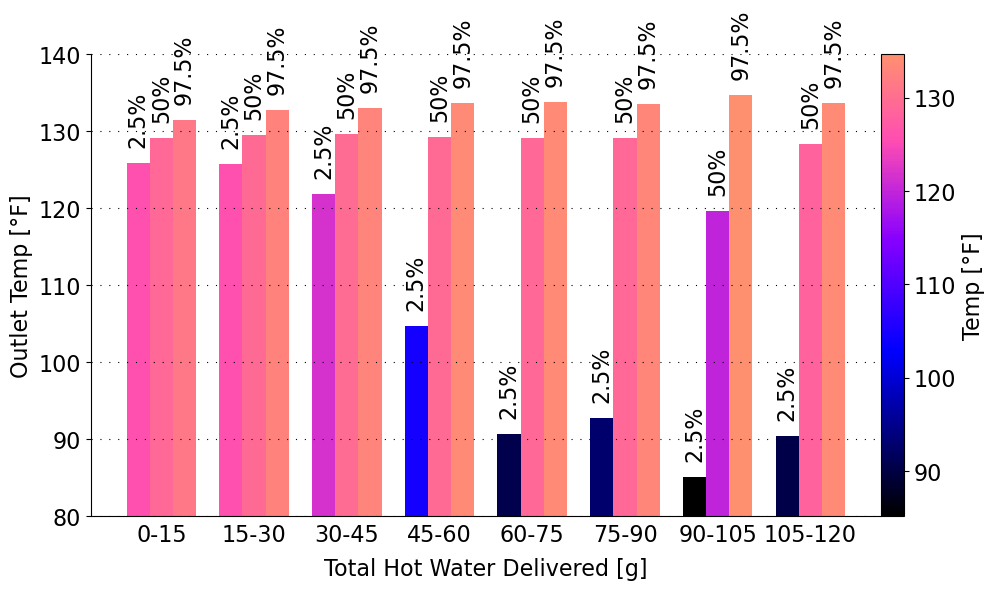

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os

# ---------------- UNIVERSAL FONT SIZE ----------------
A = 16  # font size for all labels

# ---------------- FILES ----------------
DRAW_FILE = r"C:\Users\danap\OCHRE_Working\Homes_HotWater_Use.csv"
BASELINE_PARQUET = r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed110_Control.parquet"

# ---------------- LOAD DATA ----------------
df_draw = pd.read_csv(DRAW_FILE)
df_temp = pd.read_parquet(BASELINE_PARQUET)

# ---------------- FILTER DEAD BAND ----------------
target_deadband = round(8.3333, 2)
df_temp = df_temp[np.round(df_temp['Deadband_C'], 2) == target_deadband]

# ---------------- COMPUTE PER-HOME 2.5/50/97.5 ----------------
TEMP_COL = "Hot Water Outlet Temperature (C)"
df_temp['Temp_F'] = df_temp[TEMP_COL] * 9/5 + 32

df_stats = df_temp.groupby('Home')['Temp_F'].agg(
    Temp_2_5=lambda x: np.percentile(x, 2.5),
    Temp_50=lambda x: np.percentile(x, 50),
    Temp_97_5=lambda x: np.percentile(x, 97.5)
).reset_index()

# ---------------- MERGE WITH TOTAL DRAW ----------------
df = df_draw.merge(df_stats, on='Home', how='inner')

# ---------------- TOTAL DRAW BINS ----------------
BIN_WIDTH = 15
min_draw = 0
max_draw = np.ceil(df['Total_Draw_gal'].max()/BIN_WIDTH)*BIN_WIDTH
bins = np.arange(min_draw, max_draw+BIN_WIDTH, BIN_WIDTH)
df['Draw_Bin'] = pd.cut(df['Total_Draw_gal'], bins=bins, labels=False, include_lowest=True)

# ---------------- PER-BIN MEDIANS ----------------
bin_stats = df.groupby('Draw_Bin').agg({
    'Temp_2_5':'median',
    'Temp_50':'median',
    'Temp_97_5':'median',
    'Home':'count'
}).reset_index()

# ---------------- PLOTTING ----------------
fig, ax = plt.subplots(figsize=(12,6))
x = np.arange(len(bin_stats))
width = 0.25

# ---------------- COLOR MAP ----------------
cmap = plt.colormaps['gnuplot2']
cmap_trunc = LinearSegmentedColormap.from_list('gnuplot2_trunc', cmap(np.linspace(0, 0.7, 256)))
temp_min = bin_stats[['Temp_2_5','Temp_50','Temp_97_5']].min().min()
temp_max = bin_stats[['Temp_2_5','Temp_50','Temp_97_5']].max().max()
norm = plt.Normalize(vmin=temp_min, vmax=temp_max)

# ---------------- PLOT BARS ----------------
bars_2_5 = ax.bar(x - width, bin_stats['Temp_2_5'], width,
                  color=cmap_trunc(norm(bin_stats['Temp_2_5'])), label='2.5th percentile')
bars_50  = ax.bar(x,         bin_stats['Temp_50'], width,
                  color=cmap_trunc(norm(bin_stats['Temp_50'])), label='Median')
bars_97_5= ax.bar(x + width, bin_stats['Temp_97_5'], width,
                  color=cmap_trunc(norm(bin_stats['Temp_97_5'])), label='97.5th percentile')

# ---------------- REMOVE DEFAULT X TICKS ----------------
ax.set_xticks([])  # removes the 1,2,3… tick labels

# ---------------- LABELS ON TOP OF BARS ----------------
rotation_angle = 90
padding = 2  # vertical offset above the bar
for bars, label_text in zip([bars_2_5, bars_50, bars_97_5], ['2.5%', '50%', '97.5%']):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + padding, label_text,
                ha='center', va='bottom', fontsize=A, rotation=rotation_angle)

# ---------------- BIN RANGE LABELS BELOW ----------------
y_offset =79
for xi, b_start, b_end in zip(x, bins[:-1], bins[1:]):
    ax.text(xi, y_offset, f"{int(b_start)}-{int(b_end)}", ha='center', va='top', fontsize=A)

# ---------------- AXES LABELS ----------------
ax.set_ylabel('Outlet Temp [°F]', fontsize=A)
ax.set_xlabel(f'Total Hot Water Delivered [g]', fontsize=A, labelpad=30)
ax.set_ylim(80,140)
ax.tick_params(axis='y', labelsize=A)

# ---------------- COLORBAR ----------------
sm = plt.cm.ScalarMappable(cmap=cmap_trunc, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.0)
cbar.set_label('Temp [°F]', fontsize=A)
cbar.ax.tick_params(labelsize=A)

# ---------------- REMOVE TOP AND RIGHT SPINES ----------------
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle=(0, (1, 7)), color='black', linewidth=0.8)


RESULTS_DIR = r"C:\Users\danap\OCHRE_Working\Figs"
FILENAME = "180110_1_3_Shed110_DB15_BarChart_95CI.pdf"
filepath = os.path.join(RESULTS_DIR, FILENAME)
# plt.savefig(filepath, format='pdf', bbox_inches='tight', pad_inches=0)

# plt.tight_layout()

# ---------------- ADD BIN RANGE LABELS ----------------
bin_stats['Draw_Range_gal'] = [
    f"{int(bins[i])}-{int(bins[i+1])}"
    for i in bin_stats['Draw_Bin']
]

# ---------------- SELECT AND REORDER COLUMNS ----------------
temp_table = bin_stats[[
    'Draw_Range_gal',
    'Temp_2_5',
    'Temp_50',
    'Temp_97_5',
    'Home'
]].rename(columns={
    'Temp_2_5': 'Outlet Temp 2.5% [°F]',
    'Temp_50':  'Outlet Temp 50% [°F]',
    'Temp_97_5':'Outlet Temp 97.5% [°F]',
    'Home':     'Homes in Bin'
})

# ---------------- ROUND FOR READABILITY ----------------
temp_table[['Outlet Temp 2.5% [°F]',
            'Outlet Temp 50% [°F]',
            'Outlet Temp 97.5% [°F]']] = (
    temp_table[['Outlet Temp 2.5% [°F]',
                'Outlet Temp 50% [°F]',
                'Outlet Temp 97.5% [°F]']].round(0)
)

# ---------------- PRINT TABLE ----------------
print("\nHot Water Outlet Temperature by Total Draw Bin:\n")
print(temp_table.to_string(index=False))

plt.show()



In [11]:
import pandas as pd
import numpy as np
import os

# ================== USER SETTINGS ==================

DRAW_FILE = r"C:\Users\danap\OCHRE_Working\Homes_HotWater_Use.csv"

BASELINE_PARQUETS = [
    r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed100_Control.parquet",
    r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed105_Control.parquet",
    r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed110_Control.parquet",
    r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed115_Control.parquet",
    r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed120_Control.parquet",
    r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed125_Control.parquet",
]

# Deadbands to evaluate (°F)
DEADBANDS_F = [5, 10, 15]

BIN_WIDTH = 15  # gallons

# ===================================================


def compute_pivot_table(
    parquet_path,
    df_draw,
    bins,
    target_deadband_F
):
    """
    Returns:
        pivot_table : Percentile x Draw_Bin table of outlet temp [°F]
        counts      : Homes per draw bin
    """

    # ---------------- LOAD BASELINE ----------------
    df_temp = pd.read_parquet(parquet_path)

    # ---------------- DEAD BAND FILTER ----------------
    target_deadband_C = target_deadband_F * 5 / 9

    df_temp = df_temp[
        np.isclose(
            df_temp['Deadband_C'],
            target_deadband_C,
            atol=0.01
        )
    ]

    if df_temp.empty:
        return None, None

    # ---------------- TEMPERATURE TO °F ----------------
    TEMP_COL = "Hot Water Outlet Temperature (C)"
    df_temp['Temp_F'] = df_temp[TEMP_COL] * 9 / 5 + 32

    # ---------------- PER-HOME PERCENTILES ----------------
    df_stats = df_temp.groupby('Home')['Temp_F'].agg(
        Temp_2_5=lambda x: np.percentile(x, 2.5),
        Temp_50=lambda x: np.percentile(x, 50),
        Temp_97_5=lambda x: np.percentile(x, 97.5)
    ).reset_index()

    # ---------------- MERGE WITH DRAWS ----------------
    df = df_draw.merge(df_stats, on='Home', how='inner')

    df['Draw_Bin'] = pd.cut(
        df['Total_Draw_gal'],
        bins=bins,
        labels=False,
        include_lowest=True,
        right=False   # ← FIX
    )

    # ---------------- BIN MEDIANS ----------------
    bin_stats = df.groupby('Draw_Bin').agg(
        Temp_2_5=('Temp_2_5', 'median'),
        Temp_50=('Temp_50', 'median'),
        Temp_97_5=('Temp_97_5', 'median'),
        Homes=('Home', 'count')
    ).reset_index()

    # ---------------- BIN LABELS ----------------
    bin_stats['Draw_Range_gal'] = [
        f"{int(bins[i])}-{int(bins[i+1])}"
        for i in bin_stats['Draw_Bin']
    ]

    # ---------------- LONG → PIVOT ----------------
    long = bin_stats.melt(
        id_vars=['Draw_Range_gal', 'Homes'],
        value_vars=['Temp_2_5', 'Temp_50', 'Temp_97_5'],
        var_name='Percentile',
        value_name='Outlet Temp [°F]'
    )

    percentile_map = {
        'Temp_2_5': '2.5%',
        'Temp_50': '50%',
        'Temp_97_5': '97.5%'
    }
    long['Percentile'] = long['Percentile'].map(percentile_map)

    pivot = (
        long.pivot(
            index='Percentile',
            columns='Draw_Range_gal',
            values='Outlet Temp [°F]'
        )
    )
    
    # enforce numeric bin order
    ordered_cols = [
        f"{int(bins[i])}-{int(bins[i+1])}"
        for i in range(len(bins) - 1)
        if f"{int(bins[i])}-{int(bins[i+1])}" in pivot.columns
    ]
    
    pivot = (
        pivot[ordered_cols]
        .reindex(['97.5%', '50%', '2.5%'])
        .round(0)
    )



    counts = bin_stats[['Draw_Range_gal', 'Homes']]

    return pivot, counts


# ================== MAIN SCRIPT ==================

if __name__ == "__main__":

    # ---------------- LOAD DRAW DATA ----------------
    df_draw = pd.read_csv(DRAW_FILE)

    # ---------------- BUILD BINS ----------------
    min_draw = 0
    max_draw = np.ceil(df_draw['Total_Draw_gal'].max() / BIN_WIDTH) * BIN_WIDTH
    bins = np.arange(min_draw, max_draw + BIN_WIDTH, BIN_WIDTH)

    # ---------------- LOOP OVER FILES & DEADBANDS ----------------
    for parquet in BASELINE_PARQUETS:
        for deadband_F in DEADBANDS_F:

            pivot_table, counts = compute_pivot_table(
                parquet,
                df_draw,
                bins,
                deadband_F
            )

            print("\n" + "=" * 100)
            print(f"File     : {os.path.basename(parquet)}")
            print(f"Deadband : {deadband_F} °F")
            print("=" * 100)

            if pivot_table is None:
                print("No data found for this deadband.")
                continue

            print("\nHot Water Outlet Temperature [°F]")
            print(pivot_table.to_string())

            print("\nHomes per Draw Bin")
            print(counts.to_string(index=False))



File     : 180110_1_3_Shed100_Control.parquet
Deadband : 5 °F

Hot Water Outlet Temperature [°F]
Draw_Range_gal   0-15  15-30  30-45  45-60  60-75  75-90  90-105  105-120
Percentile                                                               
97.5%           131.0  133.0  133.0  133.0  133.0  134.0   135.0    132.0
50%             129.0  130.0  130.0  129.0  129.0  128.0   130.0    129.0
2.5%            126.0  126.0  119.0  100.0   90.0   97.0    84.0     94.0

Homes per Draw Bin
Draw_Range_gal  Homes
          0-15    111
         15-30    166
         30-45     72
         45-60     35
         60-75     16
         75-90      5
        90-105      1
       105-120      2

File     : 180110_1_3_Shed100_Control.parquet
Deadband : 10 °F

Hot Water Outlet Temperature [°F]
Draw_Range_gal   0-15  15-30  30-45  45-60  60-75  75-90  90-105  105-120
Percentile                                                               
97.5%           131.0  133.0  133.0  133.0  134.0  134.0   135.0   

In [17]:
import pandas as pd
import numpy as np
import os
import csv

# ================== USER SETTINGS ==================

DRAW_FILE = r"C:\Users\danap\OCHRE_Working\Homes_HotWater_Use.csv"

BASELINE_PARQUETS = [
    r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed100_Control.parquet",
    r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed105_Control.parquet",
    r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed110_Control.parquet",
    r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed115_Control.parquet",
    r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed120_Control.parquet",
    r"C:\Users\danap\OCHRE_Working\180110_1_3_Shed125_Control.parquet",
]

DEADBANDS_F = [5, 10, 15]  # Deadbands to evaluate (°F)
BIN_WIDTH = 15  # gallons

# ===================================================

def compute_pivot_table(parquet_path, df_draw, bins, target_deadband_F):
    """Return pivot table of median outlet temps per percentile per draw bin."""
    df_temp = pd.read_parquet(parquet_path)

    # Deadband filter
    target_deadband_C = target_deadband_F * 5 / 9
    df_temp = df_temp[np.isclose(df_temp['Deadband_C'], target_deadband_C, atol=0.01)]
    if df_temp.empty:
        return None

    # Convert to °F
    TEMP_COL = "Hot Water Outlet Temperature (C)"
    df_temp['Temp_F'] = df_temp[TEMP_COL] * 9 / 5 + 32

    # Per-home percentiles
    df_stats = df_temp.groupby('Home')['Temp_F'].agg(
        Temp_2_5=lambda x: np.percentile(x, 2.5),
        Temp_50=lambda x: np.percentile(x, 50),
        Temp_97_5=lambda x: np.percentile(x, 97.5)
    ).reset_index()

    # Merge with draws
    df = df_draw.merge(df_stats, on='Home', how='inner')

    df['Draw_Bin'] = pd.cut(
        df['Total_Draw_gal'],
        bins=bins,
        labels=False,
        include_lowest=True,
        right=False
    )

    # Bin medians
    bin_stats = df.groupby('Draw_Bin').agg(
        Temp_2_5=('Temp_2_5', 'median'),
        Temp_50=('Temp_50', 'median'),
        Temp_97_5=('Temp_97_5', 'median')
    ).reset_index()

    # Draw range labels
    bin_stats['Draw_Range_gal'] = [
        f"{int(bins[i])}-{int(bins[i+1])}" for i in bin_stats['Draw_Bin']
    ]

    # Long format → pivot
    long = bin_stats.melt(
        id_vars='Draw_Range_gal',
        value_vars=['Temp_2_5', 'Temp_50', 'Temp_97_5'],
        var_name='Percentile',
        value_name='Outlet Temp [°F]'
    )
    percentile_map = {'Temp_2_5': '2.5%', 'Temp_50': '50%', 'Temp_97_5': '97.5%'}
    long['Percentile'] = long['Percentile'].map(percentile_map)

    pivot = long.pivot(index='Draw_Range_gal', columns='Percentile', values='Outlet Temp [°F]')
    pivot = pivot[['97.5%', '50%', '2.5%']].round(0)
    return pivot

# ================== MAIN SCRIPT ==================

if __name__ == "__main__":

    df_draw = pd.read_csv(DRAW_FILE)
    min_draw = 0
    max_draw = np.ceil(df_draw['Total_Draw_gal'].max() / BIN_WIDTH) * BIN_WIDTH
    bins = np.arange(min_draw, max_draw + BIN_WIDTH, BIN_WIDTH)

    all_sheds = []

    for parquet in BASELINE_PARQUETS:
        shed_name = os.path.basename(parquet).replace(".parquet", "")
        all_tables = []

        for deadband in sorted(DEADBANDS_F, reverse=True):  # 15 → 10 → 5
            pivot = compute_pivot_table(parquet, df_draw, bins, deadband)
            if pivot is None:
                continue
            # Rename columns to include deadband + shed name
            pivot.columns = [f"{percentile}_DB{deadband}_{shed_name}" for percentile in pivot.columns]
            all_tables.append(pivot)

        if not all_tables:
            print(f"No data for {shed_name}")
            continue

        # Concatenate horizontally by Draw_Range_gal for this shed
        shed_table = pd.concat(all_tables, axis=1)
        shed_table.insert(0, 'Draw_Bin', shed_table.index)
        all_sheds.append(shed_table)

    if all_sheds:
        # Concatenate all sheds vertically
        final_csv = pd.concat(all_sheds, axis=0, ignore_index=True)
        csv_file = r"C:\Users\danap\OCHRE_Working\180110_1_3_All95CI.csv"
        final_csv.to_csv(csv_file, index=False)
        print(f"Saved CSV: {csv_file}")
    else:
        print("No data found for any shed.")



Saved CSV: C:\Users\danap\OCHRE_Working\180110_1_3_All95CI.csv
